# Inputs

In [1]:
splitPartCount = 5
splitSeed = 27
hoursPerWindow = 1

# Preproccess

## read data

In [2]:
from utils.class_patient import Patients


patients = Patients.loadPatients()
len(patients)

1213

## remove missing

In [3]:
# fill measures whose null represent false value

from constants import NULLABLE_MEASURES


nullableMeasures = NULLABLE_MEASURES

for measureName in nullableMeasures:
    patients.fillMissingMeasureValue(measureName, 0)

In [4]:
# remove measures with less than 80% of data

measures = patients.getMeasures()

for measure, count in measures.items():
    if count < len(patients) * 80 / 100:
        patients.removeMeasures([measure])
        print(measure, count)

pco2 917
ph 954
po2 917
albumin 406
hba1c 326
lymphocyte 446
height 415
urine-ketone 294
crp 19


In [5]:
# remove patients with less than 80% of data

patients.removePatientByMissingFeatures()
len(patients)

1206

In [6]:
# # remove patients with positive tag in first 12 hours

from pandas import Timedelta


patients.removePatientAkiEarly(Timedelta(hours=12))

82

In [7]:
print("Total ", len(patients))
print("AKI ", sum([1 for p in patients if p.akdPositive]))
print("Ratio ", sum([1 for p in patients if p.akdPositive]) / len(patients))

Total  1124
AKI  392
Ratio  0.3487544483985765


## split patients

In [8]:
splitedPatients = patients.split(splitPartCount, splitSeed)

len(splitedPatients[0])

225

In [9]:
splitedPatients = patients.split(splitPartCount, splitSeed)


def trainTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        yield trainPatients, testPatients


def trainValTest():
    for i in range(splitedPatients.__len__()):
        testPatients = splitedPatients[i]

        trainPatientsList = splitedPatients[:i] + splitedPatients[i + 1 :]
        trainPatients = Patients(patients=[])
        for trainPatientsElem in trainPatientsList:
            trainPatients += trainPatientsElem

        *trainPatients, valPatients = trainPatients.split(5, 27)
        tmpPatients = Patients(patients=[])
        for trainPatientsElem in trainPatients:
            tmpPatients += trainPatientsElem
        trainPatients = tmpPatients

        yield trainPatients, valPatients, testPatients

In [10]:
for trainPatients, testPatients in trainTest():
    print(len(trainPatients.patientList), len(testPatients.patientList))

899 225
899 225
899 225
899 225
900 224


# Transformer

### Transformer

### Using transformer

In [11]:
from official.nlp.modeling.models import TransformerEncoder
from official.nlp.configs import encoders

# # Configuration for the Transformer encoder
# encoder_config = encoders.TransformerEncoderConfig(
#     vocab_size=30522,  # Use a large enough vocab size if working with tokenized text; adjust if needed
#     hidden_size=128,  # Example hidden size
#     num_layers=2,  # Example number of layers
#     num_attention_heads=4,  # Example number of attention heads
#     intermediate_size=512,  # Size of the feed-forward network's intermediate layer
#     activation="gelu",
#     dropout_rate=0.1,
#     attention_dropout_rate=0.1,
#     max_sequence_length=512,  # Max length of input sequences
#     type_vocab_size=2,
# )

import keras

@keras.saving.register_keras_serializable()
class ArrayToBooleanModel(keras.Model):
    def __init__(self, **kwargs):
        super(ArrayToBooleanModel, self).__init__(**kwargs)
        self.transformer_encoder = TransformerEncoder(
            dropout_rate=0.1,
            attention_dropout_rate=0.1,
            # max_sequence_length=max_sequence_length,
            # vocab_size=vocab_size,
        )
        self.pooling = keras.layers.GlobalAveragePooling1D()
        self.dense = keras.layers.Dense(
            1, activation="sigmoid"
        )  # Output a single boolean value

    def call(self, inputs, training=False):
        x = self.transformer_encoder(inputs, training=training)
        x = self.pooling(x)
        x = self.dense(x)
        return x


def createTransformerModel(timeSteps, features):
    from tensorflow.keras.optimizers import Adam
    model = ArrayToBooleanModel()

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss="binary_crossentropy",
        metrics=["AUC", "accuracy", "precision", "recall"],
    )

    return model

2024-08-17 14:41:48.366900: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 14:41:48.374340: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-17 14:41:48.382887: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-17 14:41:48.385694: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-17 14:41:48.393172: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
from utils.prepare_data import normalizeData, patientsToNumpy
from constants import CATEGORICAL_MEASURES
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping


if __name__ == "__main__":

    loses = []
    aucs = []
    accuracies = []
    precisions = []
    recals = []

    train_loss_list = []
    val_loss_list = []
    models = []

    for i, (trainPatients, valPatients, testPatients) in enumerate(trainValTest()):
        npTrainX, categoryEncoder, numericEncoder, oulier, columns = patientsToNumpy(
            trainPatients, 
            hoursPerWindow,
            CATEGORICAL_MEASURES,
            timeSeriesOnly=True,
            fromHour=0,
            toHour=12,
        )

        npTestX, *_ = patientsToNumpy(
            testPatients,
            hoursPerWindow,
            CATEGORICAL_MEASURES,
            columns,
            categoryEncoder,
            numericEncoder,
            oulier,
            timeSeriesOnly=True,
            fromHour=0,
            toHour=12,
        )

        npValX, *_ = patientsToNumpy(
            valPatients,
            hoursPerWindow,
            CATEGORICAL_MEASURES,
            columns,
            categoryEncoder,
            numericEncoder,
            oulier,
            timeSeriesOnly=True,
            fromHour=0,
            toHour=12,
        )

        npTrainX = np.nan_to_num(npTrainX, nan=0)
        npTestX = np.nan_to_num(npTestX, nan=0)
        npValX = np.nan_to_num(npValX, nan=0)

        ################### Static ###################
        staticTrainX = trainPatients.getMeasuresBetween(measureTypes="static")
        staticTestX = testPatients.getMeasuresBetween(measureTypes="static")
        staticValX = valPatients.getMeasuresBetween(measureTypes="static")

        staticTrainX = staticTrainX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])
        staticTestX = staticTestX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])
        staticValX = staticValX.drop(columns=["subject_id", "hadm_id", "stay_id", "akd"])

        staticTrainX, staticTestX, staticValX = normalizeData(
            staticTrainX, staticTestX, staticValX
        )

        staticLen = len(staticTrainX.columns)

        staticTrainX = staticTrainX.to_numpy().astype(np.float32)
        staticTestX = staticTestX.to_numpy().astype(np.float32)
        staticValX = staticValX.to_numpy().astype(np.float32) # type: ignore

        staticTrainX = np.nan_to_num(staticTrainX, nan=0)
        staticTestX = np.nan_to_num(staticTestX, nan=0)
        staticValX = np.nan_to_num(staticValX, nan=0)

        ################### labels ###################
        trainY = [p.akdPositive for p in trainPatients]
        testY = [p.akdPositive for p in testPatients]
        valY = [p.akdPositive for p in valPatients]

        # model = createModel2(npTrainX.shape[1], npTrainX.shape[2], staticLen)

        neg, pos = np.bincount(trainY)
        weight0 = (1 / neg) * (len(trainY)) / 2.0
        weight1 = (1 / pos) * (len(trainY)) / 2.0
        weight = {0: weight0, 1: weight1}

        # expand static data to be time steps as time series data
        staticTrainX = np.expand_dims(staticTrainX, axis=1)
        staticTrainX = np.repeat(staticTrainX, npTrainX.shape[1], axis=1)

        staticTestX = np.expand_dims(staticTestX, axis=1)
        staticTestX = np.repeat(staticTestX, npTestX.shape[1], axis=1)

        staticValX = np.expand_dims(staticValX, axis=1)
        staticValX = np.repeat(staticValX, npValX.shape[1], axis=1)

        # append to npX
        npTrainX = np.concatenate([npTrainX, staticTrainX], axis=2)
        npTestX = np.concatenate([npTestX, staticTestX], axis=2)
        npValX = np.concatenate([npValX, staticValX], axis=2)


        early_stopping = EarlyStopping(
                monitor="val_loss", patience=50, restore_best_weights=True
            )

        model = createTransformerModel(npTrainX.shape[1], npTrainX.shape[2] + staticLen)
        history = model.fit(
                npTrainX,
                np.array(trainY),
                epochs=1000,
                batch_size=32,
                validation_data=(npValX, np.array(valY)),
                class_weight=weight,
                callbacks=[early_stopping],
            )

        loss, auc, accuracy, precison, recal = model.evaluate(npTestX, np.array(testY)) 
                    
        model.save(f"result/transformer_{i}.h5")

        models.append(model)
        loses.append(loss)
        aucs.append(auc)
        accuracies.append(accuracy)
        precisions.append(precison)
        recals.append(recal)

        train_loss_list.append(history.history['loss'])
        val_loss_list.append(history.history['val_loss'])

        pass

In [15]:

print("Loses:", loses, np.mean(loses), np.std(loses))
print("AUCs:", aucs, np.mean(aucs), np.std(aucs))
print("Accuracies:", accuracies, np.mean(accuracies), np.std(accuracies))
print("Precisions:", precisions, np.mean(precisions), np.std(precisions))
print("Recals:", recals, np.mean(recals), np.std(recals));

Loses: [0.49162814021110535, 0.5027989149093628, 0.54948890209198, 0.554831326007843, 0.6029706597328186] 0.5403435885906219 0.03999619673670938
AUCs: [0.830673336982727, 0.8234345316886902, 0.8130309581756592, 0.8150251507759094, 0.7968915104866028] 0.8158110976219177 0.011360462762973915
Accuracies: [0.800000011920929, 0.7333333492279053, 0.7288888692855835, 0.7155555486679077, 0.6964285969734192] 0.734841275215149 0.035016679009820785
Precisions: [0.7037037014961243, 0.6022727489471436, 0.5865384340286255, 0.5700934529304504, 0.5409836173057556] 0.6007183909416198 0.055345444991231826
Recals: [0.7307692170143127, 0.6794871687889099, 0.7721518874168396, 0.7721518874168396, 0.8461538553237915] 0.7601428031921387 0.05487162513095322


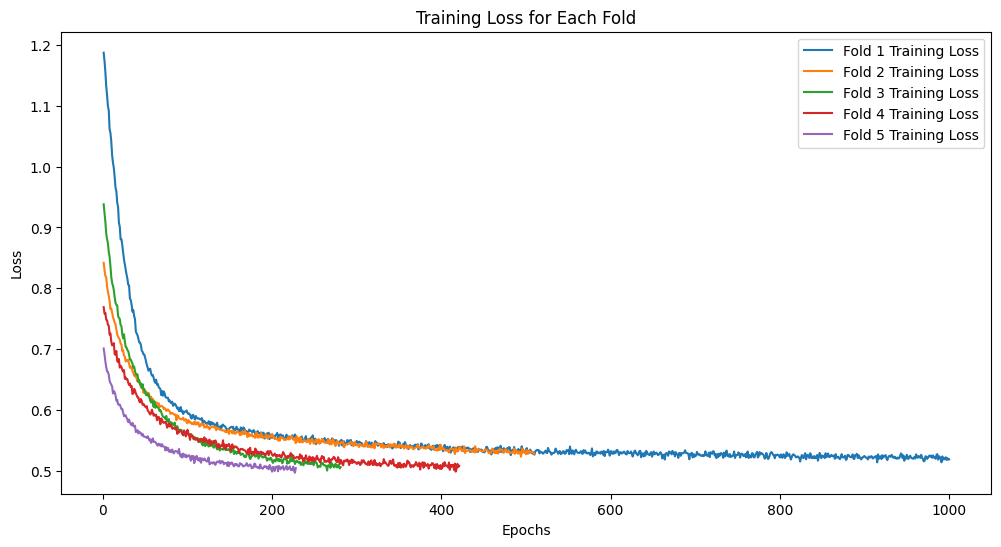

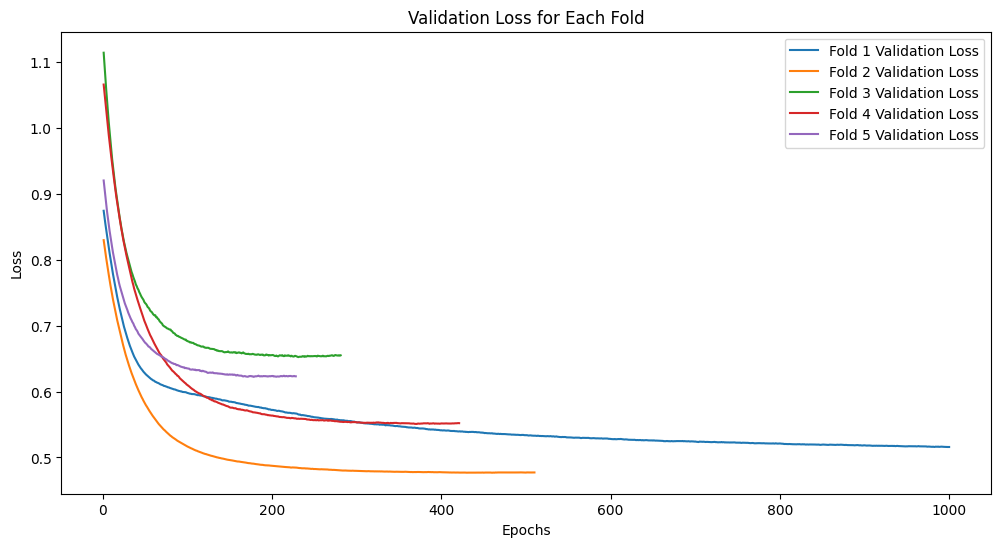

In [17]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))
for i, train_loss in enumerate(train_loss_list):
    plt.plot(
        range(1, len(train_loss) + 1), train_loss, label=f"Fold {i+1} Training Loss"
    )
plt.title("Training Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_train_loss.svg")
plt.show()

# Plot the validation loss for each fold
plt.figure(figsize=(12, 6))
for i, val_loss in enumerate(val_loss_list):
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=f"Fold {i+1} Validation Loss")
plt.title("Validation Loss for Each Fold")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("result/transformer_val_loss.svg")
plt.show()